# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [7]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


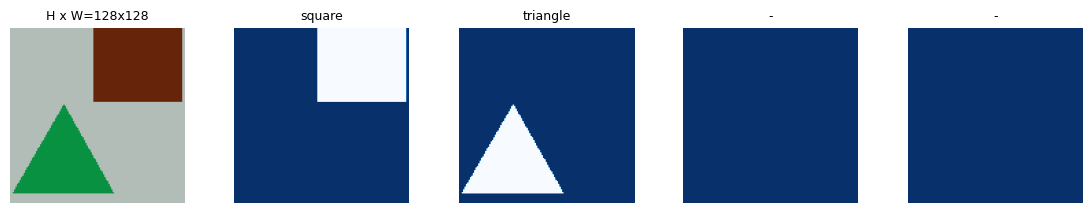

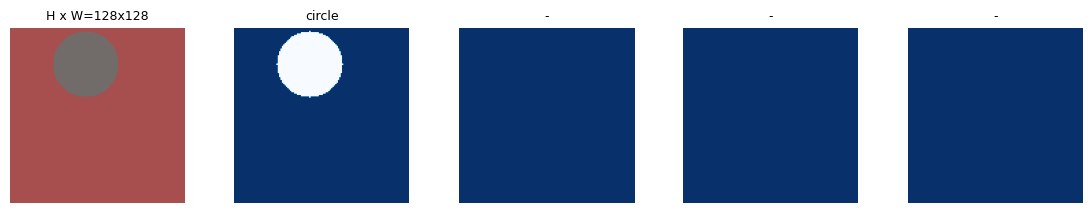

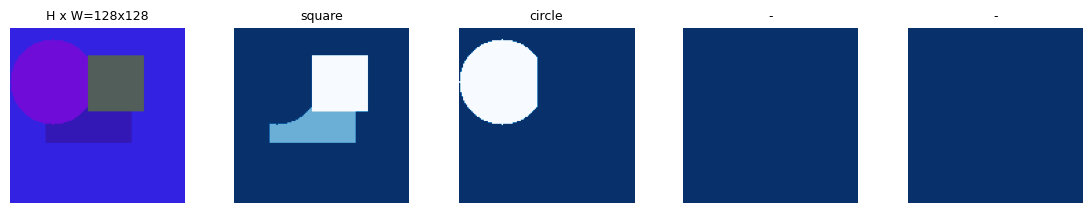

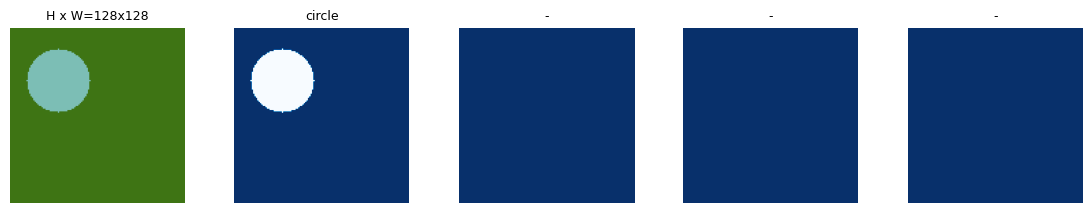

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: G:\My Drive\02_Python_Projects\Mask_RCNN\logs\shapes20230910T0929\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/1


C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

  1/100 [..............................] - ETA: 1:02:56 - loss: 7.3069 - rpn_class_loss: 0.0944 - rpn_bbox_loss: 2.4291 - mrcnn_class_loss: 1.9686 - mrcnn_bbox_loss: 1.1183 - mrcnn_mask_loss: 1.6966

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

  2/100 [..............................] - ETA: 52:16 - loss: 7.1109 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 2.1404 - mrcnn_class_loss: 1.7307 - mrcnn_bbox_loss: 1.1940 - mrcnn_mask_loss: 1.9572  

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

  3/100 [..............................] - ETA: 48:27 - loss: 6.9423 - rpn_class_loss: 0.0824 - rpn_bbox_loss: 1.9551 - mrcnn_class_loss: 1.5156 - mrcnn_bbox_loss: 1.2894 - mrcnn_mask_loss: 2.0999

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

  4/100 [>.............................] - ETA: 46:04 - loss: 6.6404 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 1.9070 - mrcnn_class_loss: 1.4309 - mrcnn_bbox_loss: 1.2779 - mrcnn_mask_loss: 1.9300

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

  5/100 [>.............................] - ETA: 44:33 - loss: 6.4479 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 1.8274 - mrcnn_class_loss: 1.3568 - mrcnn_bbox_loss: 1.2608 - mrcnn_mask_loss: 1.9096

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

  6/100 [>.............................] - ETA: 43:12 - loss: 6.2296 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 1.7783 - mrcnn_class_loss: 1.3113 - mrcnn_bbox_loss: 1.2357 - mrcnn_mask_loss: 1.8122

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

  7/100 [=>............................] - ETA: 42:18 - loss: 6.0265 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 1.6662 - mrcnn_class_loss: 1.2470 - mrcnn_bbox_loss: 1.2211 - mrcnn_mask_loss: 1.8044

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

  8/100 [=>............................] - ETA: 41:22 - loss: 5.8889 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.6648 - mrcnn_class_loss: 1.1844 - mrcnn_bbox_loss: 1.1882 - mrcnn_mask_loss: 1.7666

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

  9/100 [=>............................] - ETA: 40:43 - loss: 5.7071 - rpn_class_loss: 0.0852 - rpn_bbox_loss: 1.6271 - mrcnn_class_loss: 1.1424 - mrcnn_bbox_loss: 1.1445 - mrcnn_mask_loss: 1.7079

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 10/100 [==>...........................] - ETA: 39:58 - loss: 5.5396 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.6072 - mrcnn_class_loss: 1.0907 - mrcnn_bbox_loss: 1.1180 - mrcnn_mask_loss: 1.6395

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 11/100 [==>...........................] - ETA: 39:24 - loss: 5.3436 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 1.5460 - mrcnn_class_loss: 1.0464 - mrcnn_bbox_loss: 1.0957 - mrcnn_mask_loss: 1.5735

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 12/100 [==>...........................] - ETA: 38:55 - loss: 5.1642 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.4948 - mrcnn_class_loss: 1.0005 - mrcnn_bbox_loss: 1.0773 - mrcnn_mask_loss: 1.5123

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 13/100 [==>...........................] - ETA: 38:30 - loss: 5.0405 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.4827 - mrcnn_class_loss: 0.9670 - mrcnn_bbox_loss: 1.0606 - mrcnn_mask_loss: 1.4507

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 14/100 [===>..........................] - ETA: 37:57 - loss: 4.9258 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 1.4727 - mrcnn_class_loss: 0.9288 - mrcnn_bbox_loss: 1.0356 - mrcnn_mask_loss: 1.4103

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 15/100 [===>..........................] - ETA: 37:24 - loss: 4.7871 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 1.4262 - mrcnn_class_loss: 0.8987 - mrcnn_bbox_loss: 1.0197 - mrcnn_mask_loss: 1.3645

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 16/100 [===>..........................] - ETA: 36:49 - loss: 4.6404 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.3782 - mrcnn_class_loss: 0.8682 - mrcnn_bbox_loss: 0.9990 - mrcnn_mask_loss: 1.3195

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 17/100 [====>.........................] - ETA: 36:16 - loss: 4.5135 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.3352 - mrcnn_class_loss: 0.8434 - mrcnn_bbox_loss: 0.9760 - mrcnn_mask_loss: 1.2845

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 18/100 [====>.........................] - ETA: 35:45 - loss: 4.4021 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 1.2964 - mrcnn_class_loss: 0.8264 - mrcnn_bbox_loss: 0.9563 - mrcnn_mask_loss: 1.2497

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 19/100 [====>.........................] - ETA: 35:13 - loss: 4.2923 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.2629 - mrcnn_class_loss: 0.8052 - mrcnn_bbox_loss: 0.9356 - mrcnn_mask_loss: 1.2166

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 20/100 [=====>........................] - ETA: 34:42 - loss: 4.1873 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 1.2290 - mrcnn_class_loss: 0.7841 - mrcnn_bbox_loss: 0.9195 - mrcnn_mask_loss: 1.1830

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 21/100 [=====>........................] - ETA: 34:14 - loss: 4.0982 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 1.2010 - mrcnn_class_loss: 0.7692 - mrcnn_bbox_loss: 0.9012 - mrcnn_mask_loss: 1.1556

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 22/100 [=====>........................] - ETA: 33:40 - loss: 4.0026 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.1662 - mrcnn_class_loss: 0.7509 - mrcnn_bbox_loss: 0.8855 - mrcnn_mask_loss: 1.1301

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 23/100 [=====>........................] - ETA: 33:12 - loss: 3.9292 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.1538 - mrcnn_class_loss: 0.7303 - mrcnn_bbox_loss: 0.8709 - mrcnn_mask_loss: 1.1049

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 24/100 [======>.......................] - ETA: 32:41 - loss: 3.8481 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 1.1285 - mrcnn_class_loss: 0.7138 - mrcnn_bbox_loss: 0.8549 - mrcnn_mask_loss: 1.0825

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 25/100 [======>.......................] - ETA: 32:10 - loss: 3.7776 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.1061 - mrcnn_class_loss: 0.6990 - mrcnn_bbox_loss: 0.8424 - mrcnn_mask_loss: 1.0628

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 26/100 [======>.......................] - ETA: 31:42 - loss: 3.7164 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.0900 - mrcnn_class_loss: 0.6871 - mrcnn_bbox_loss: 0.8275 - mrcnn_mask_loss: 1.0457

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 27/100 [=======>......................] - ETA: 31:13 - loss: 3.6566 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.0694 - mrcnn_class_loss: 0.6769 - mrcnn_bbox_loss: 0.8155 - mrcnn_mask_loss: 1.0299

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 28/100 [=======>......................] - ETA: 30:45 - loss: 3.5880 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.0508 - mrcnn_class_loss: 0.6636 - mrcnn_bbox_loss: 0.7969 - mrcnn_mask_loss: 1.0129

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 29/100 [=======>......................] - ETA: 30:15 - loss: 3.5474 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.0457 - mrcnn_class_loss: 0.6520 - mrcnn_bbox_loss: 0.7864 - mrcnn_mask_loss: 1.0003

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 30/100 [========>.....................] - ETA: 29:47 - loss: 3.4923 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.0241 - mrcnn_class_loss: 0.6435 - mrcnn_bbox_loss: 0.7762 - mrcnn_mask_loss: 0.9864

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 31/100 [========>.....................] - ETA: 29:20 - loss: 3.4375 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 1.0092 - mrcnn_class_loss: 0.6328 - mrcnn_bbox_loss: 0.7628 - mrcnn_mask_loss: 0.9715

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 32/100 [========>.....................] - ETA: 28:53 - loss: 3.3932 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 0.9975 - mrcnn_class_loss: 0.6231 - mrcnn_bbox_loss: 0.7524 - mrcnn_mask_loss: 0.9599

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 33/100 [========>.....................] - ETA: 28:26 - loss: 3.3548 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 0.9829 - mrcnn_class_loss: 0.6163 - mrcnn_bbox_loss: 0.7462 - mrcnn_mask_loss: 0.9501

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 34/100 [=========>....................] - ETA: 27:58 - loss: 3.3151 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.9717 - mrcnn_class_loss: 0.6105 - mrcnn_bbox_loss: 0.7356 - mrcnn_mask_loss: 0.9389

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 35/100 [=========>....................] - ETA: 27:30 - loss: 3.2706 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 0.9636 - mrcnn_class_loss: 0.5977 - mrcnn_bbox_loss: 0.7224 - mrcnn_mask_loss: 0.9292

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 36/100 [=========>....................] - ETA: 27:05 - loss: 3.2335 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 0.9490 - mrcnn_class_loss: 0.5928 - mrcnn_bbox_loss: 0.7152 - mrcnn_mask_loss: 0.9200

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 37/100 [==========>...................] - ETA: 26:37 - loss: 3.1909 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 0.9396 - mrcnn_class_loss: 0.5807 - mrcnn_bbox_loss: 0.7056 - mrcnn_mask_loss: 0.9094

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 38/100 [==========>...................] - ETA: 26:11 - loss: 3.1532 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 0.9283 - mrcnn_class_loss: 0.5733 - mrcnn_bbox_loss: 0.6973 - mrcnn_mask_loss: 0.8995

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 39/100 [==========>...................] - ETA: 25:45 - loss: 3.1168 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 0.9162 - mrcnn_class_loss: 0.5671 - mrcnn_bbox_loss: 0.6895 - mrcnn_mask_loss: 0.8899

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 40/100 [===========>..................] - ETA: 25:18 - loss: 3.0715 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 0.9043 - mrcnn_class_loss: 0.5559 - mrcnn_bbox_loss: 0.6780 - mrcnn_mask_loss: 0.8804

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 41/100 [===========>..................] - ETA: 24:53 - loss: 3.0415 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.8944 - mrcnn_class_loss: 0.5507 - mrcnn_bbox_loss: 0.6719 - mrcnn_mask_loss: 0.8724

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 42/100 [===========>..................] - ETA: 24:26 - loss: 3.0108 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.8825 - mrcnn_class_loss: 0.5466 - mrcnn_bbox_loss: 0.6659 - mrcnn_mask_loss: 0.8646

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 43/100 [===========>..................] - ETA: 24:01 - loss: 2.9750 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 0.8738 - mrcnn_class_loss: 0.5375 - mrcnn_bbox_loss: 0.6568 - mrcnn_mask_loss: 0.8564

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 44/100 [============>.................] - ETA: 23:34 - loss: 2.9392 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.8648 - mrcnn_class_loss: 0.5292 - mrcnn_bbox_loss: 0.6477 - mrcnn_mask_loss: 0.8480

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 45/100 [============>.................] - ETA: 23:09 - loss: 2.9123 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.8573 - mrcnn_class_loss: 0.5237 - mrcnn_bbox_loss: 0.6411 - mrcnn_mask_loss: 0.8411

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 46/100 [============>.................] - ETA: 22:43 - loss: 2.8833 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.8464 - mrcnn_class_loss: 0.5169 - mrcnn_bbox_loss: 0.6369 - mrcnn_mask_loss: 0.8347

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 47/100 [=============>................] - ETA: 22:17 - loss: 2.8554 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.8418 - mrcnn_class_loss: 0.5094 - mrcnn_bbox_loss: 0.6288 - mrcnn_mask_loss: 0.8277

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 48/100 [=============>................] - ETA: 21:52 - loss: 2.8290 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.8340 - mrcnn_class_loss: 0.5046 - mrcnn_bbox_loss: 0.6225 - mrcnn_mask_loss: 0.8208

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 49/100 [=============>................] - ETA: 21:27 - loss: 2.7987 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.8253 - mrcnn_class_loss: 0.4971 - mrcnn_bbox_loss: 0.6161 - mrcnn_mask_loss: 0.8135

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 50/100 [==============>...............] - ETA: 21:02 - loss: 2.7865 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.8292 - mrcnn_class_loss: 0.4940 - mrcnn_bbox_loss: 0.6100 - mrcnn_mask_loss: 0.8072

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 51/100 [==============>...............] - ETA: 20:37 - loss: 2.7579 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.8221 - mrcnn_class_loss: 0.4873 - mrcnn_bbox_loss: 0.6026 - mrcnn_mask_loss: 0.8004

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 52/100 [==============>...............] - ETA: 20:12 - loss: 2.7384 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.8154 - mrcnn_class_loss: 0.4842 - mrcnn_bbox_loss: 0.5978 - mrcnn_mask_loss: 0.7961

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 53/100 [==============>...............] - ETA: 19:46 - loss: 2.7130 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.8083 - mrcnn_class_loss: 0.4784 - mrcnn_bbox_loss: 0.5915 - mrcnn_mask_loss: 0.7904

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 54/100 [===============>..............] - ETA: 19:21 - loss: 2.6917 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.8029 - mrcnn_class_loss: 0.4741 - mrcnn_bbox_loss: 0.5859 - mrcnn_mask_loss: 0.7848

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 55/100 [===============>..............] - ETA: 18:55 - loss: 2.6698 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.7988 - mrcnn_class_loss: 0.4682 - mrcnn_bbox_loss: 0.5797 - mrcnn_mask_loss: 0.7797

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 56/100 [===============>..............] - ETA: 18:30 - loss: 2.6468 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.7933 - mrcnn_class_loss: 0.4635 - mrcnn_bbox_loss: 0.5730 - mrcnn_mask_loss: 0.7741

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 57/100 [================>.............] - ETA: 18:05 - loss: 2.6254 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.7870 - mrcnn_class_loss: 0.4589 - mrcnn_bbox_loss: 0.5680 - mrcnn_mask_loss: 0.7690

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 58/100 [================>.............] - ETA: 17:39 - loss: 2.6021 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.7810 - mrcnn_class_loss: 0.4540 - mrcnn_bbox_loss: 0.5622 - mrcnn_mask_loss: 0.7629

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 59/100 [================>.............] - ETA: 17:14 - loss: 2.5854 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.7773 - mrcnn_class_loss: 0.4506 - mrcnn_bbox_loss: 0.5577 - mrcnn_mask_loss: 0.7581

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 60/100 [=================>............] - ETA: 16:49 - loss: 2.5600 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.7709 - mrcnn_class_loss: 0.4446 - mrcnn_bbox_loss: 0.5516 - mrcnn_mask_loss: 0.7518

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 61/100 [=================>............] - ETA: 16:24 - loss: 2.5380 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.7653 - mrcnn_class_loss: 0.4393 - mrcnn_bbox_loss: 0.5469 - mrcnn_mask_loss: 0.7459

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 62/100 [=================>............] - ETA: 15:58 - loss: 2.5171 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.7600 - mrcnn_class_loss: 0.4344 - mrcnn_bbox_loss: 0.5417 - mrcnn_mask_loss: 0.7407

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 63/100 [=================>............] - ETA: 15:33 - loss: 2.4978 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.7548 - mrcnn_class_loss: 0.4307 - mrcnn_bbox_loss: 0.5365 - mrcnn_mask_loss: 0.7360

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 64/100 [==================>...........] - ETA: 15:08 - loss: 2.4779 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.7522 - mrcnn_class_loss: 0.4256 - mrcnn_bbox_loss: 0.5300 - mrcnn_mask_loss: 0.7307

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 65/100 [==================>...........] - ETA: 14:43 - loss: 2.4601 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.7489 - mrcnn_class_loss: 0.4211 - mrcnn_bbox_loss: 0.5246 - mrcnn_mask_loss: 0.7265

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 66/100 [==================>...........] - ETA: 14:18 - loss: 2.4406 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.7440 - mrcnn_class_loss: 0.4163 - mrcnn_bbox_loss: 0.5201 - mrcnn_mask_loss: 0.7216

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 67/100 [===================>..........] - ETA: 13:52 - loss: 2.4227 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.7377 - mrcnn_class_loss: 0.4126 - mrcnn_bbox_loss: 0.5160 - mrcnn_mask_loss: 0.7181

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 68/100 [===================>..........] - ETA: 13:27 - loss: 2.4097 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.7331 - mrcnn_class_loss: 0.4098 - mrcnn_bbox_loss: 0.5134 - mrcnn_mask_loss: 0.7155

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 69/100 [===================>..........] - ETA: 13:02 - loss: 2.3994 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.7312 - mrcnn_class_loss: 0.4082 - mrcnn_bbox_loss: 0.5099 - mrcnn_mask_loss: 0.7123

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 70/100 [====================>.........] - ETA: 12:36 - loss: 2.3847 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.7273 - mrcnn_class_loss: 0.4049 - mrcnn_bbox_loss: 0.5063 - mrcnn_mask_loss: 0.7088

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 71/100 [====================>.........] - ETA: 12:11 - loss: 2.3708 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.7233 - mrcnn_class_loss: 0.4025 - mrcnn_bbox_loss: 0.5023 - mrcnn_mask_loss: 0.7054

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 72/100 [====================>.........] - ETA: 11:46 - loss: 2.3533 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.7183 - mrcnn_class_loss: 0.3994 - mrcnn_bbox_loss: 0.4977 - mrcnn_mask_loss: 0.7011

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 73/100 [====================>.........] - ETA: 11:21 - loss: 2.3407 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.7136 - mrcnn_class_loss: 0.3980 - mrcnn_bbox_loss: 0.4942 - mrcnn_mask_loss: 0.6984

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 74/100 [=====================>........] - ETA: 10:56 - loss: 2.3259 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.7102 - mrcnn_class_loss: 0.3951 - mrcnn_bbox_loss: 0.4902 - mrcnn_mask_loss: 0.6942

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 75/100 [=====================>........] - ETA: 10:30 - loss: 2.3097 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.7056 - mrcnn_class_loss: 0.3921 - mrcnn_bbox_loss: 0.4859 - mrcnn_mask_loss: 0.6901

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 76/100 [=====================>........] - ETA: 10:05 - loss: 2.2961 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.7026 - mrcnn_class_loss: 0.3892 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.6868

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 77/100 [======================>.......] - ETA: 9:40 - loss: 2.2825 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.6994 - mrcnn_class_loss: 0.3865 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.6829 

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 78/100 [======================>.......] - ETA: 9:15 - loss: 2.2708 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6958 - mrcnn_class_loss: 0.3852 - mrcnn_bbox_loss: 0.4749 - mrcnn_mask_loss: 0.6796

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 79/100 [======================>.......] - ETA: 8:50 - loss: 2.2588 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6940 - mrcnn_class_loss: 0.3824 - mrcnn_bbox_loss: 0.4719 - mrcnn_mask_loss: 0.6758

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 80/100 [=======================>......] - ETA: 8:24 - loss: 2.2427 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.6897 - mrcnn_class_loss: 0.3794 - mrcnn_bbox_loss: 0.4678 - mrcnn_mask_loss: 0.6712

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 81/100 [=======================>......] - ETA: 7:59 - loss: 2.2329 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.6865 - mrcnn_class_loss: 0.3780 - mrcnn_bbox_loss: 0.4656 - mrcnn_mask_loss: 0.6684

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 82/100 [=======================>......] - ETA: 7:34 - loss: 2.2214 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.6844 - mrcnn_class_loss: 0.3755 - mrcnn_bbox_loss: 0.4624 - mrcnn_mask_loss: 0.6649

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 83/100 [=======================>......] - ETA: 7:09 - loss: 2.2087 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.6818 - mrcnn_class_loss: 0.3727 - mrcnn_bbox_loss: 0.4589 - mrcnn_mask_loss: 0.6614

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 84/100 [========================>.....] - ETA: 6:44 - loss: 2.1972 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.6786 - mrcnn_class_loss: 0.3709 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.6581

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 85/100 [========================>.....] - ETA: 6:18 - loss: 2.1849 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.6756 - mrcnn_class_loss: 0.3683 - mrcnn_bbox_loss: 0.4528 - mrcnn_mask_loss: 0.6548

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 86/100 [========================>.....] - ETA: 5:53 - loss: 2.1744 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.6724 - mrcnn_class_loss: 0.3665 - mrcnn_bbox_loss: 0.4502 - mrcnn_mask_loss: 0.6520

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 87/100 [=========================>....] - ETA: 5:28 - loss: 2.1642 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.6694 - mrcnn_class_loss: 0.3643 - mrcnn_bbox_loss: 0.4479 - mrcnn_mask_loss: 0.6493

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 88/100 [=========================>....] - ETA: 5:03 - loss: 2.1520 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.6669 - mrcnn_class_loss: 0.3618 - mrcnn_bbox_loss: 0.4449 - mrcnn_mask_loss: 0.6454

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 89/100 [=========================>....] - ETA: 4:37 - loss: 2.1423 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.6635 - mrcnn_class_loss: 0.3597 - mrcnn_bbox_loss: 0.4429 - mrcnn_mask_loss: 0.6433

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 90/100 [==========================>...] - ETA: 4:12 - loss: 2.1308 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.6603 - mrcnn_class_loss: 0.3577 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.6400

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 91/100 [==========================>...] - ETA: 3:47 - loss: 2.1225 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.6584 - mrcnn_class_loss: 0.3564 - mrcnn_bbox_loss: 0.4379 - mrcnn_mask_loss: 0.6373

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 92/100 [==========================>...] - ETA: 3:22 - loss: 2.1112 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.6561 - mrcnn_class_loss: 0.3542 - mrcnn_bbox_loss: 0.4348 - mrcnn_mask_loss: 0.6338

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 93/100 [==========================>...] - ETA: 2:56 - loss: 2.1023 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.6539 - mrcnn_class_loss: 0.3522 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.6315

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 94/100 [===========================>..] - ETA: 2:31 - loss: 2.0924 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.6516 - mrcnn_class_loss: 0.3503 - mrcnn_bbox_loss: 0.4302 - mrcnn_mask_loss: 0.6283

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 95/100 [===========================>..] - ETA: 2:06 - loss: 2.0821 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.6499 - mrcnn_class_loss: 0.3482 - mrcnn_bbox_loss: 0.4272 - mrcnn_mask_loss: 0.6249

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 96/100 [===========================>..] - ETA: 1:41 - loss: 2.0710 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6471 - mrcnn_class_loss: 0.3459 - mrcnn_bbox_loss: 0.4248 - mrcnn_mask_loss: 0.6213

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 97/100 [============================>.] - ETA: 1:15 - loss: 2.0617 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.6449 - mrcnn_class_loss: 0.3443 - mrcnn_bbox_loss: 0.4221 - mrcnn_mask_loss: 0.6188

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 98/100 [============================>.] - ETA: 50s - loss: 2.0532 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.6426 - mrcnn_class_loss: 0.3430 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.6163 

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

 99/100 [============================>.] - ETA: 25s - loss: 2.0456 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.6401 - mrcnn_class_loss: 0.3419 - mrcnn_bbox_loss: 0.4181 - mrcnn_mask_loss: 0.6142

C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66

100/100 [==============================] - 2554s 26s/step - loss: 2.0384 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.6385 - mrcnn_class_loss: 0.3411 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.6115 - val_loss: 1.2549 - val_rpn_class_loss: 0.0137 - val_rpn_bbox_loss: 0.4689 - val_mrcnn_class_loss: 0.1832 - val_mrcnn_bbox_loss: 0.2522 - val_mrcnn_mask_loss: 0.3368



In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [13]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  G:\My Drive\02_Python_Projects\Mask_RCNN\logs\shapes20230910T0929\mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


In [16]:
image_id = random.choice(dataset_val.image_ids)
image_id

5

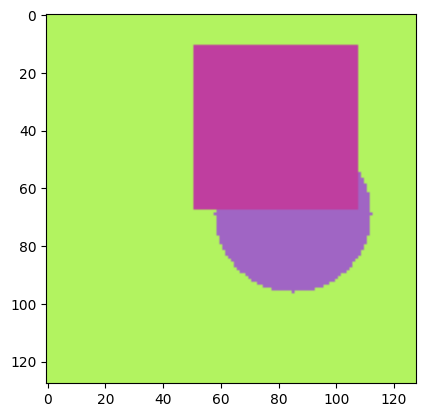

In [19]:
plt.imshow(original_image)

original_image           shape: (128, 128, 3)         min:   62.00000  max:  243.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:   11.00000  max:  113.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


C:\Users\kokil\anaconda3\envs\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


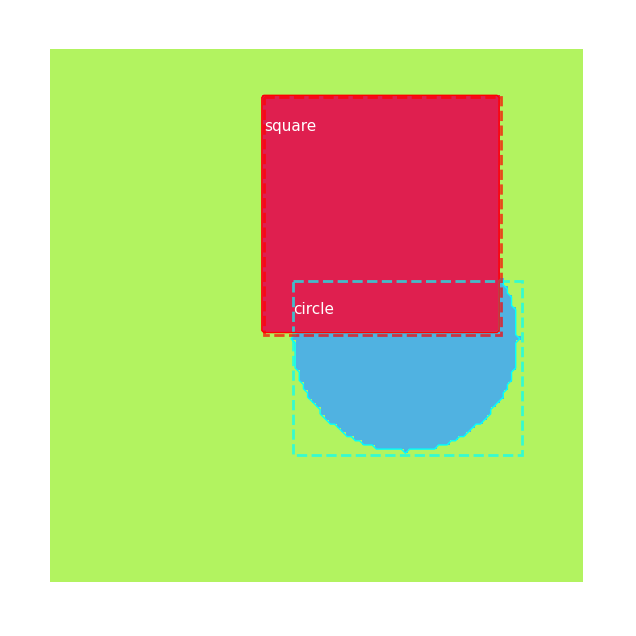

In [18]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


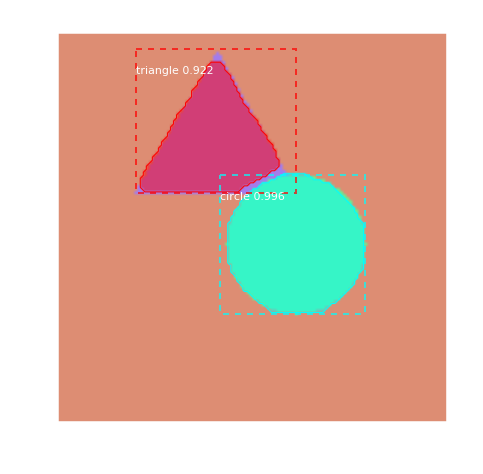

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
